In [35]:
import re
from functools import lru_cache
import random
import json

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tiktoken
from sklearn.preprocessing import MultiLabelBinarizer

In [36]:
from openai import OpenAI

client = OpenAI(
    api_key="",
)

In [37]:
def validate_penal_codes(model_output, actual_answer):
    # Clean and standardize the inputs
    def clean_string(s):
        return re.findall(r'Section \d+(?:\([a-z]\))? in The Indian Penal Code', s.replace('"', '').replace("'", ""))
    
    model_codes = clean_string(model_output)
    actual_codes = clean_string(actual_answer)
    
    # Calculate matches
    correct_matches = set(model_codes) & set(actual_codes)
    missing_codes = set(actual_codes) - set(model_codes)
    extra_codes = set(model_codes) - set(actual_codes)
    
    # Calculate score
    total_codes = len(set(actual_codes))
    score = len(correct_matches) / total_codes if total_codes > 0 else 0
    
    # Adjust score for extra codes
    if extra_codes:
        score -= 0.1 * len(extra_codes)
    score = max(0, min(score, 1))  # Ensure score is between 0 and 1
    
    return {
        'score': round(score, 2),
        'correct_matches': list(correct_matches),
        'missing_codes': list(missing_codes),
        'extra_codes': list(extra_codes)
    }

In [38]:
encoding = tiktoken.get_encoding("cl100k_base")
MAX_TOKEN_LENGTH = 16384

@lru_cache()
def get_testing_file_data():
    test_data = []
    with open('../data/test.jsonl', 'r') as test_json:
        lines = test_json.readlines()    
        for i, line in enumerate(lines):
            test_data.append(json.loads(line))
    return test_data

def convert_raw_json_to_openai_format(prompt, expected):
    return dict({
        "system": "Process the following legal case details and provide the relevant sections of the Indian Penal Code.",
        "prompt": prompt,
        "expected": expected
    })
def get_random_line_from_testing_file():
    test_data = get_testing_file_data()
    while True:
        index = random.randint(0, len(test_data))
        selected = test_data[index]
        text = " ".join(selected["text"])
        if len(encoding.encode(text)) < MAX_TOKEN_LENGTH:
            expected = ", ".join(selected['labels'])
            return convert_raw_json_to_openai_format(text, expected)

In [39]:
fine_tune_model_id = "ft:gpt-3.5-turbo-0125:dview:court-laws-ipc-v3:9tVzLrGk"

In [40]:
random_sample = get_random_line_from_testing_file()
test_messages = []
test_messages.append({"role": "system", "content": random_sample["system"]})
test_messages.append({"role": "user", "content": random_sample["prompt"]})

In [41]:
response = client.chat.completions.create(
    model = fine_tune_model_id,
    messages = test_messages
)

print(response.choices[0].message.content)

Section 302 in The Indian Penal Code, Section 304 in The Indian Penal Code


In [42]:
def get_model_prediction(prompt, model="gpt-3.5-turbo"):
    test_messages = [
        {"role": "system", "content": "Process the following legal case details and provide the relevant sections of the Indian Penal Code."},
        {"role": "user", "content": prompt}
    ]
    
    response = client.chat.completions.create(
        model=model,
        messages=test_messages
    )
    
    return response.choices[0].message.content.strip()

In [43]:
def sanitize_labels(labels):
    """
    Sanitize a list of labels or a comma-separated string of labels.
    Remove brackets and their contents, and perform other cleanups.
    """
    if isinstance(labels, str):
        labels = labels.split(',')
    
    sanitized_labels = set()
    for label in labels:
        # Remove leading/trailing whitespace and convert to lowercase
        label = label.strip().lower()
        
        # Remove "in The Indian Penal Code" if present
        label = re.sub(r'\s+in\s+the\s+indian\s+penal\s+code', '', label)
        
        # Remove brackets and their contents
        label = re.sub(r'\([^)]*\)', '', label)
        
        # Remove any remaining whitespace and add to set if not empty
        label = label.strip()
        matches = re.findall(r'(?:section|sec\.?)\s*(\d+(?:/\d+)?)', label)
        sanitized_labels.update(matches)
    
    return sorted(sanitized_labels, key=lambda x: tuple(map(int, x.split('/'))))

In [44]:
def evaluate_model(random_samples, model: str):
    true_labels = []
    predicted_labels = []
    
    for random_sample in random_samples:
        expected = sanitize_labels(random_sample["expected"])
        prediction = sanitize_labels(get_model_prediction(random_sample["prompt"], model))
                
        true_labels.append(expected)
        predicted_labels.append(prediction)
    
     # Combine all labels to ensure MultiLabelBinarizer knows about all possible labels
    all_labels = set()
    for labels in true_labels + predicted_labels:
        all_labels.update(labels)
    
    # Use MultiLabelBinarizer to transform labels into a binary matrix
    mlb = MultiLabelBinarizer(classes=sorted(all_labels))
    true_labels_binary = mlb.fit_transform(true_labels)
    predicted_labels_binary = mlb.transform(predicted_labels)
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels_binary, predicted_labels_binary)
    precision = precision_score(true_labels_binary, predicted_labels_binary, average='micro', zero_division=0)
    recall = recall_score(true_labels_binary, predicted_labels_binary, average='micro', zero_division=0)
    f1 = f1_score(true_labels_binary, predicted_labels_binary, average='micro', zero_division=0)
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "expected": true_labels,
        "prediction": predicted_labels
    }

In [53]:
n = 10  # Number of evaluations
random_samples = []
for _ in range(n):
    random_samples.append(get_random_line_from_testing_file())
fine_tuned_results = evaluate_model(random_samples, model=fine_tune_model_id)
print(f"Evaluation results for model: {fine_tune_model_id} after {n} runs:")
print(f"Accuracy: {fine_tuned_results['accuracy']:.4f}")
print(f"Precision: {fine_tuned_results['precision']:.4f}")
print(f"Recall: {fine_tuned_results['recall']:.4f}")
print(f"F1 Score: {fine_tuned_results['f1_score']:.4f}")


model = "gpt-3.5-turbo"
base_results = evaluate_model(random_samples, model="gpt-3.5-turbo")
print(f"Evaluation results for model: {model} after {n} runs:")
print(f"Evaluation results for {n} runs:")
print(f"Accuracy: {base_results['accuracy']:.4f}")
print(f"Precision: {base_results['precision']:.4f}")
print(f"Recall: {base_results['recall']:.4f}")
print(f"F1 Score: {base_results['f1_score']:.4f}")

Evaluation results for model: ft:gpt-3.5-turbo-0125:dview:court-laws-ipc-v3:9tVzLrGk after 10 runs:
Accuracy: 0.3000
Precision: 0.8400
Recall: 0.6176
F1 Score: 0.7119
Evaluation results for model: gpt-3.5-turbo after 10 runs:
Evaluation results for 10 runs:
Accuracy: 0.1000
Precision: 0.5750
Recall: 0.6765
F1 Score: 0.6216


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from itertools import chain

In [47]:
def plot_metrics_comparison(fine_tuned_results, base_results):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    fine_tuned_values = [fine_tuned_results[metric] for metric in metrics]
    base_values = [base_results[metric] for metric in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, fine_tuned_values, width, label='Fine-tuned Model')
    rects2 = ax.bar(x + width/2, base_values, width, label='Base Model')

    ax.set_ylabel('Scores')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.show()

In [48]:
def plot_confusion_matrices(fine_tuned_results, base_results):
    def create_confusion_matrix(true_labels, predicted_labels):
        # Flatten the list of lists into a single list of labels
        all_labels = list(set(chain.from_iterable(true_labels + predicted_labels)))
        
        # Create binary matrices for true and predicted labels
        true_matrix = np.zeros((len(true_labels), len(all_labels)))
        pred_matrix = np.zeros((len(predicted_labels), len(all_labels)))
        
        for i, labels in enumerate(true_labels):
            for label in labels:
                true_matrix[i, all_labels.index(label)] = 1
        
        for i, labels in enumerate(predicted_labels):
            for label in labels:
                pred_matrix[i, all_labels.index(label)] = 1
        
        cm = confusion_matrix(true_matrix.flatten(), pred_matrix.flatten())
        return cm, ['0', '1']  # We return '0' and '1' as labels for binary classification

    ft_cm, ft_labels = create_confusion_matrix(fine_tuned_results['expected'], fine_tuned_results['prediction'])
    base_cm, base_labels = create_confusion_matrix(base_results['expected'], base_results['prediction'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    sns.heatmap(ft_cm, annot=True, fmt='d', cmap='Blues', xticklabels=ft_labels, yticklabels=ft_labels, ax=ax1)
    ax1.set_title('Fine-tuned Model Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')

    sns.heatmap(base_cm, annot=True, fmt='d', cmap='Blues', xticklabels=base_labels, yticklabels=base_labels, ax=ax2)
    ax2.set_title('Base Model Confusion Matrix')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')

    plt.tight_layout()
    plt.show()

In [49]:
def plot_label_distribution(fine_tuned_results, base_results):
    def count_labels(labels):
        label_counts = {}
        for label_set in labels:
            for label in label_set:
                label_counts[label] = label_counts.get(label, 0) + 1
        return label_counts

    ft_true_counts = count_labels(fine_tuned_results['expected'])
    ft_pred_counts = count_labels(fine_tuned_results['prediction'])
    base_pred_counts = count_labels(base_results['prediction'])

    all_labels = set(ft_true_counts.keys()) | set(ft_pred_counts.keys()) | set(base_pred_counts.keys())
    
    x = np.arange(len(all_labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(15, 8))
    rects1 = ax.bar(x - width, [ft_true_counts.get(label, 0) for label in all_labels], width, label='True Labels')
    rects2 = ax.bar(x, [ft_pred_counts.get(label, 0) for label in all_labels], width, label='Fine-tuned Predictions')
    rects3 = ax.bar(x + width, [base_pred_counts.get(label, 0) for label in all_labels], width, label='Base Predictions')

    ax.set_ylabel('Count')
    ax.set_title('Label Distribution Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(all_labels, rotation=90)
    ax.legend()

    plt.tight_layout()
    plt.show()

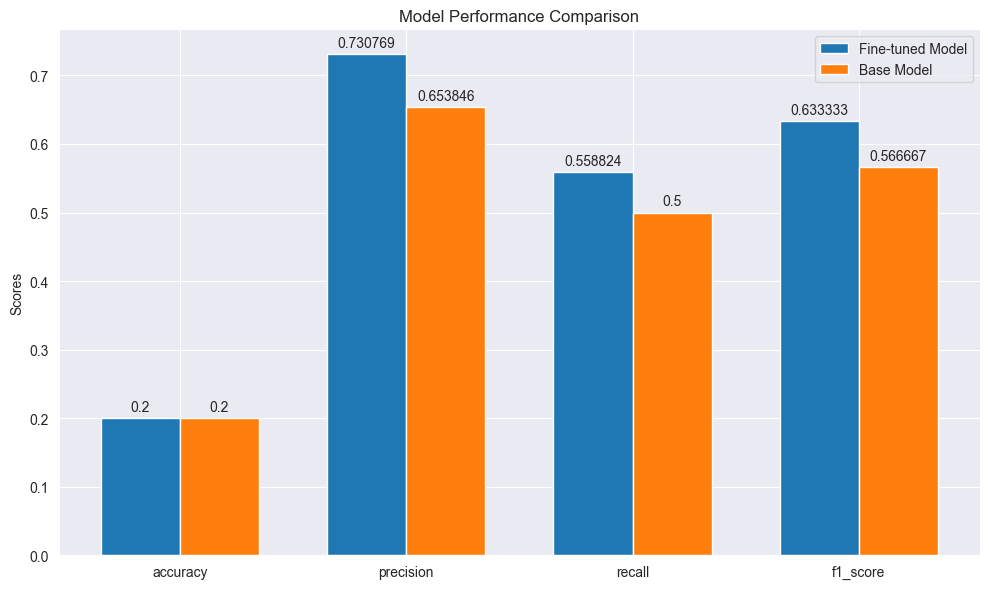

In [50]:
plot_metrics_comparison(fine_tuned_results, base_results)

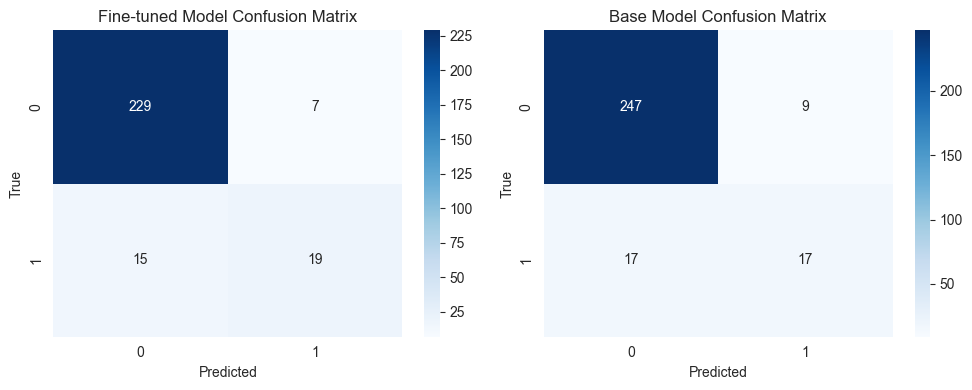

In [52]:
plot_confusion_matrices(fine_tuned_results, base_results)

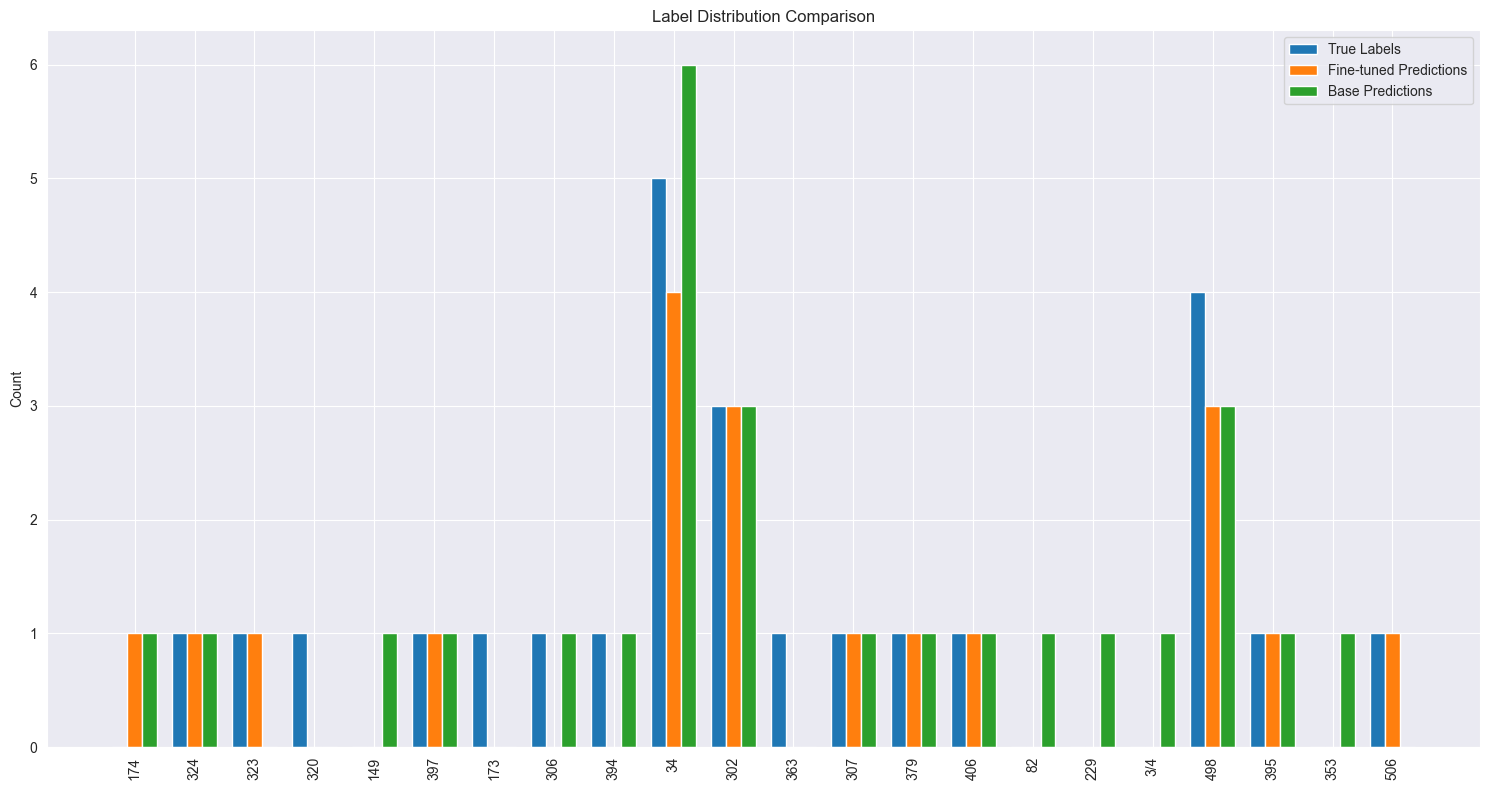

In [34]:
plot_label_distribution(fine_tuned_results, base_results)